# Latent space direction search for a beard semantic attribute

In [1]:
#@title Setup (may take a few minutes)
!git clone https://github.com/warmspringwinds/segmentation_in_style.git

import os
os.chdir(f'./segmentation_in_style')


!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

import gdown, os

url = 'https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W'
output_path = 'stylegan2-ffhq-config-f.pt'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)

Cloning into 'segmentation_in_style'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 129 (delta 54), reused 34 (delta 5), pack-reused 0
Receiving objects: 100% (129/129), 2.22 MiB | 7.37 MiB/s, done.
Resolving deltas: 100% (54/54), done.
     |████████████████████████████████| 64 kB 2.2 MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41934 sha256=a41933cc1b387ce6d427400b9ad8e7f87ed9f3ea20b3e1f23a173cd34ffcbb7c
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ftfy
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-_egj5bw8
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-_egj5bw8
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369016 sha256=1698cb58d523ab56b9c52aa8f53041f107b9d60e1ad1b8ea068b6ee324b175ad
  Sto

Downloading...
From: https://drive.google.com/uc?id=17dXYBWVEmaqnRddiV9eh8OqVoUTSn_0W
To: /content/segmentation_in_style/stylegan2-ffhq-config-f.pt
381MB [00:03, 101MB/s]


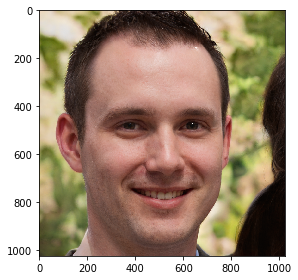

In [2]:
import argparse
import math
import os

import torch
import torchvision
from torch import optim
from tqdm import tqdm

from criteria.clip_loss import CLIPLoss
from models.stylegan2.model import Generator
import clip

g_ema = Generator(1024, 512, 8)
g_ema.load_state_dict(torch.load('stylegan2-ffhq-config-f.pt')["g_ema"], strict=False)
g_ema.eval()
g_ema = g_ema.cuda()
mean_latent = g_ema.mean_latent(4096)

truncation = 0.7

sample_z = torch.randn(1, 512).cuda()
style = g_ema.style(sample_z)
style = mean_latent + truncation * (style - mean_latent)

img_gen, _ = g_ema([style], input_is_latent=True, randomize_noise=False)

import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img

res = norm_ip(img_gen.cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()
    
io.imshow(res)
io.show()

In [3]:
import torch
import clip

description = 'A person with a beard'
text_inputs = torch.cat([clip.tokenize(description)]).cuda()

class CLIPLoss(torch.nn.Module):

    def __init__(self):
        super(CLIPLoss, self).__init__()
        self.model, self.preprocess = clip.load("ViT-B/32", device="cuda")
        self.upsample = torch.nn.Upsample(scale_factor=7)
        self.avg_pool = torch.nn.AvgPool2d(kernel_size=1024 // 32)

    def forward(self, image, text):
        image = self.avg_pool(self.upsample(image))
        #similarity = 1 - self.model(image, text)[0] / 100
        similarity = self.model(image, text)[0] / 100
        return similarity

clip_loss = CLIPLoss()


100%|███████████████████████████████████████| 354M/354M [00:05<00:00, 62.1MiB/s]


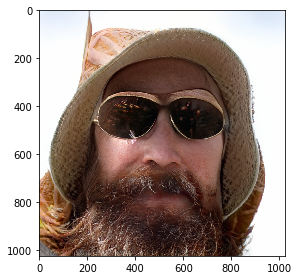

In [4]:
biggest = 0.0
winner = None
winner_latent = None

styles = []
similarity = []

with torch.no_grad():
  for i in range(5000):
    sample_z = torch.randn(1, 512).cuda()
    style = g_ema.style(sample_z)
    style = mean_latent + 1.0 * (style - mean_latent)

    img_gen, _ = g_ema([style], input_is_latent=True, randomize_noise=False)
    c_loss = clip_loss(img_gen, text_inputs)
    #print(c_loss)
    if c_loss >= biggest:
      winner = img_gen
      biggest = c_loss
      winner_latent = style
    
    styles.append(style.cpu().detach())
    similarity.append(c_loss.cpu().detach())

res = norm_ip(winner.cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy() 
io.imshow(res)
io.show()

In [5]:

tmp = torch.stack(styles).squeeze(1)
X_data = tmp.numpy()

resi = list(map(lambda x: x > 0.25, similarity))
resi = torch.stack(resi)
resi.count_nonzero()
resi = resi.squeeze()
y_data = resi.numpy()

In [6]:
resi.count_nonzero()

tensor(158)

In [7]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

# So let's find the gender direction in the latent space

clf = LogisticRegression(class_weight='balanced').fit(X_data, y_data)
direction = clf.coef_#.reshape((18, 512))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [8]:
direction.shape

(1, 512)

In [9]:
direction_torch = torch.from_numpy( direction ).cuda().float()

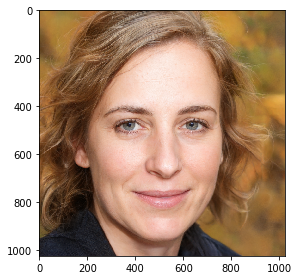

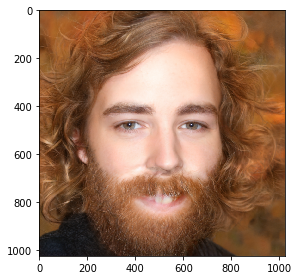

In [10]:
sample_z = torch.randn(1, 512).cuda()
style = g_ema.style(sample_z)
style = mean_latent + truncation * (style - mean_latent)

img_gen, _ = g_ema([style], input_is_latent=True, randomize_noise=False)

new_latent_vector = style.clone()
new_latent_vector = (style + 0.3*direction_torch)

img_gen_2, _ = g_ema([new_latent_vector], input_is_latent=True, randomize_noise=False)

import skimage.io as io

def norm_ip(img, min, max):
    img = img.clamp(min=min, max=max)
    img = img.add(-min).div(max - min + 1e-5)
    return img

res = norm_ip(img_gen.cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()

io.imshow(res)
io.show()

res = norm_ip(img_gen_2.cpu().detach().squeeze().permute(1, 2, 0), min=-1.0, max=1.0).numpy()

io.imshow(res)
io.show()

In [ ]:
import pickle

with open('beard_direction.pkl', 'wb') as handle:
    pickle.dump(direction, handle)